In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tabulate import tabulate
import re


def channel2Energie(c):
    return c * 0.0013902686264571718;


folder_path = "data/210417_Halbleiter/spannungen"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.TKA')]

data = {}

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    file_data = np.loadtxt(file_path, delimiter=',', skiprows=2)
    data[int(csv_file.replace('.TKA', ''))] = file_data


def gauss_function(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


def gauss_fit(data, ax, voltage):
    data_scale = data / np.sum(data)
    #threshold = 0.004
    #width = 150
    #above_threshold = np.where(data_scale > threshold)[0]
    fit_start = 0  #above_threshold[0] - width
    fit_end = len(data)  #above_threshold[-1] + width
    channels = np.arange(2, len(data) + 2)
    energies = channel2Energie(channels)
    p0 = [data_scale[fit_start:fit_end].max(), energies[data_scale.argmax()], channel2Energie(fit_end - fit_start)]
    coeff, _ = curve_fit(gauss_function, energies[fit_start:fit_end], data_scale[fit_start:fit_end], p0=p0, maxfev=10000)
    ax.scatter(energies, data_scale, marker='x')
    ax.plot(energies[fit_start:fit_end], gauss_function(energies[fit_start:fit_end], *coeff), 'r--',
            label=f'{voltage}V')
    #ax.set_xticks(list(ax.get_xticks()) + [round(coeff[1])])
    return coeff


fig, ax = plt.subplots(len(data), 1, sharex=True)
max_channels = []
coeff_table = []
for i, d in enumerate(sorted(data.keys())):
    dat = data[d]
    coeff = gauss_fit(dat, ax[i], d)
    coeff_table.append(np.concatenate(([d], coeff)))
    ax[i].set_yticklabels([])
    ax[i].grid()
    ax[i].legend()
    ax[i].set(xlim=[5.425, 5.545])
    print(f"{d}V: mu={coeff[1]:.4}mEV, sigma= {2* np.sqrt(2*np.log(2)) * coeff[2] * 1e3 :.3}kEV \n")
    print((f"{2* np.sqrt(2*np.log(2)) * coeff[2] * 1e3 :.3} & {coeff[1]:.4} \n").replace(".", ","))

ax[-1].set(xlabel="E / MeV")
fig.text(0.10, 0.5, 'I / AU', va='center', rotation='vertical')
fig.savefig("out/test_puls_width.png")

table = tabulate(coeff_table, headers=["$U / \mathrm{V}$", "$a$", "$\\mu$", "\\sigma"], tablefmt='latex')


def convert2LatexString(s):
    r = r'(\^\{\})';
    s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s


# Tabelle in eine Datei schreiben
with open('out/testpuls_width.tex', 'w') as f:
    f.write(convert2LatexString(table))

1V: mu=5.487mEV, sigma= -45.5kEV 

-45,5 & 5,487 

2V: mu=5.487mEV, sigma= -43.5kEV 

-43,5 & 5,487 

3V: mu=5.487mEV, sigma= -44.4kEV 

-44,4 & 5,487 

4V: mu=5.487mEV, sigma= -44.4kEV 

-44,4 & 5,487 

5V: mu=5.486mEV, sigma= -42.2kEV 

-42,2 & 5,486 

10V: mu=5.486mEV, sigma= -39.6kEV 

-39,6 & 5,486 

20V: mu=5.499mEV, sigma= 11.4kEV 

11,4 & 5,499 

40V: mu=5.499mEV, sigma= -10.6kEV 

-10,6 & 5,499 



In [8]:
50e3 * 0.02

1000.0

Die Diffusionsspannung beträgt: 0.35 V
Die Sperrschichtdicke beträgt: 10.27 µm


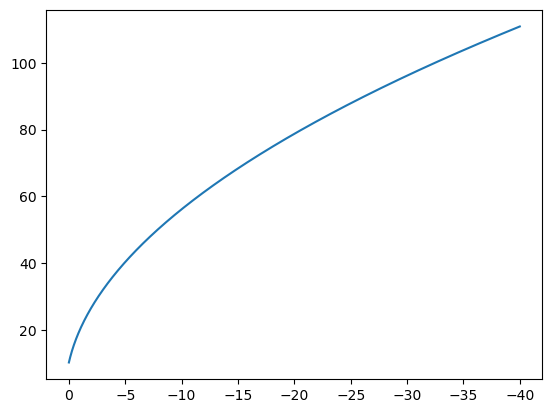

In [26]:
import math
import scipy.constants as const

# Gegebene Konstanten
e = const.e
eps_0 = const.epsilon_0
eps = 11.7  # Dielektrizitätskonstante von Silizium
n_D = 8.49e18  # Donatordichte [1/m^3]
n_A = n_D  # Akzeptordichte [1/m^3]
U_diff = 0.35  # Diffusionsspannung [V]
n_i = 1e16
T = 298
k_B = const.k


U_diff = k_B * T / e * math.log(n_D * n_A / n_i**2)
print("Die Diffusionsspannung beträgt:", round(U_diff, 2), "V")
# Berechnung der Sperrschichtdicke
U_d = -40.0
def d(U_d):
    return np.sqrt((2 * eps_0 * eps / e) * ( (1.0/ n_D) + (1.0/n_A)) * (U_diff - U_d)) * 1e6



# Ausgabe des Ergebnisses
print("Die Sperrschichtdicke beträgt:", round(d(0), 2), "µm")

Us = np.linspace(0, -40,1000)

fig, ax = plt.subplots()
ax.invert_xaxis()
ax.plot(Us, d(Us))

